---

# Ансамбли моделей

В этой работе мы рассмотрим применение некоторых классических и хорошо себя показавших алгоритмов-ансамблей. Демонстрировать работу этих алгоритмов будем на данных о потреблении электричества.

# Описание набора данных

**Author**: M. Harries, J. Gama, A. Bifet  
**Source**: [Joao Gama](http://www.inescporto.pt/~jgama/ales/ales_5.html) - 2009  
**Please cite**: None  

**Electricity** is a widely used dataset described by M. Harries and analyzed by J. Gama (see papers below). This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations.

The dataset (originally named ELEC2) contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label. The class label identifies the change of the price (UP or DOWN) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends). 

The data was normalized by A. Bifet.

### Attribute information  
* Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1
* Day: day of the week (1-7)
* Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1
* NSWprice: New South Wales electricity price, normalized between 0 and 1
* NSWdemand: New South Wales electricity demand, normalized between 0 and 1
* VICprice: Victoria electricity price, normalized between 0 and 1
* VICdemand: Victoria electricity demand, normalized between 0 and 1
* transfer: scheduled electricity transfer between both states, normalized between 0 and 1

### Relevant papers  
M. Harries. Splice-2 comparative evaluation: Electricity pricing. Technical report, The University of South Wales, 1999.  
J. Gama, P. Medas, G. Castillo, and P. Rodrigues. Learning with drift detection. In SBIA Brazilian Symposium on Artificial Intelligence, pages 286–295, 2004.

# Разведочный анализ данных

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier

Считайте набор данных в датафрейм

In [2]:
df = pd.read_csv('/Users/muzafarov/Desktop/MyEducation/ML_OE/electricity_train.csv')

При помощи метода <code>.describe()</code> изучите набор данных «с высоты птичьего полета».

In [3]:
df.describe()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
count,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000
mean,0.498293,4.006566,0.500560,0.057828,0.425939,0.003455,0.423024,0.500243,0.424536
std,0.339907,1.993551,0.294998,0.039052,0.163390,0.010175,0.120600,0.153098,0.494279
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031945,2.000000,0.255319,0.035187,0.309729,0.002283,0.373382,0.414912,0.000000
50%,0.456263,4.000000,0.510638,0.048787,0.444213,0.003467,0.422915,0.414912,0.000000
75%,0.880492,6.000000,0.765957,0.074457,0.536745,0.003467,0.468669,0.605263,1.000000
max,1.000000,7.000000,1.000000,1.000000,0.980809,1.000000,1.000000,0.959211,1.000000


Убедитесь в отсутствии пропусков. Имеет смысл проверить сбалансированность классов. Введите долю элементов класса $1$.

In [4]:
df.isna().sum()

date         0
day          0
period       0
nswprice     0
nswdemand    0
vicprice     0
vicdemand    0
transfer     0
class        0
dtype: int64

In [5]:
df['class'].value_counts(1)

class
0    0.575464
1    0.424536
Name: proportion, dtype: float64

Постройте матрицу корреляций. Определите пару наиболее коррелированных признаков.

<Axes: >

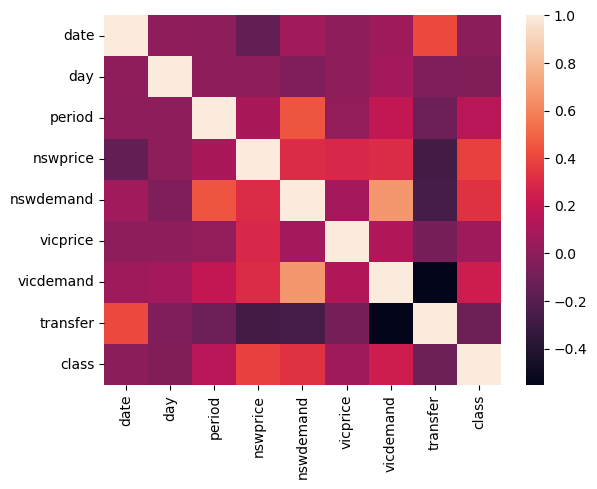

In [6]:
sns.heatmap(df.corr()) 

In [7]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df.corr(), 3))

Top Absolute Correlations
vicdemand  transfer     0.894898
nswdemand  vicdemand    0.865010
           transfer     0.737376
dtype: float64


Постройте гистограммы распределений признаков.

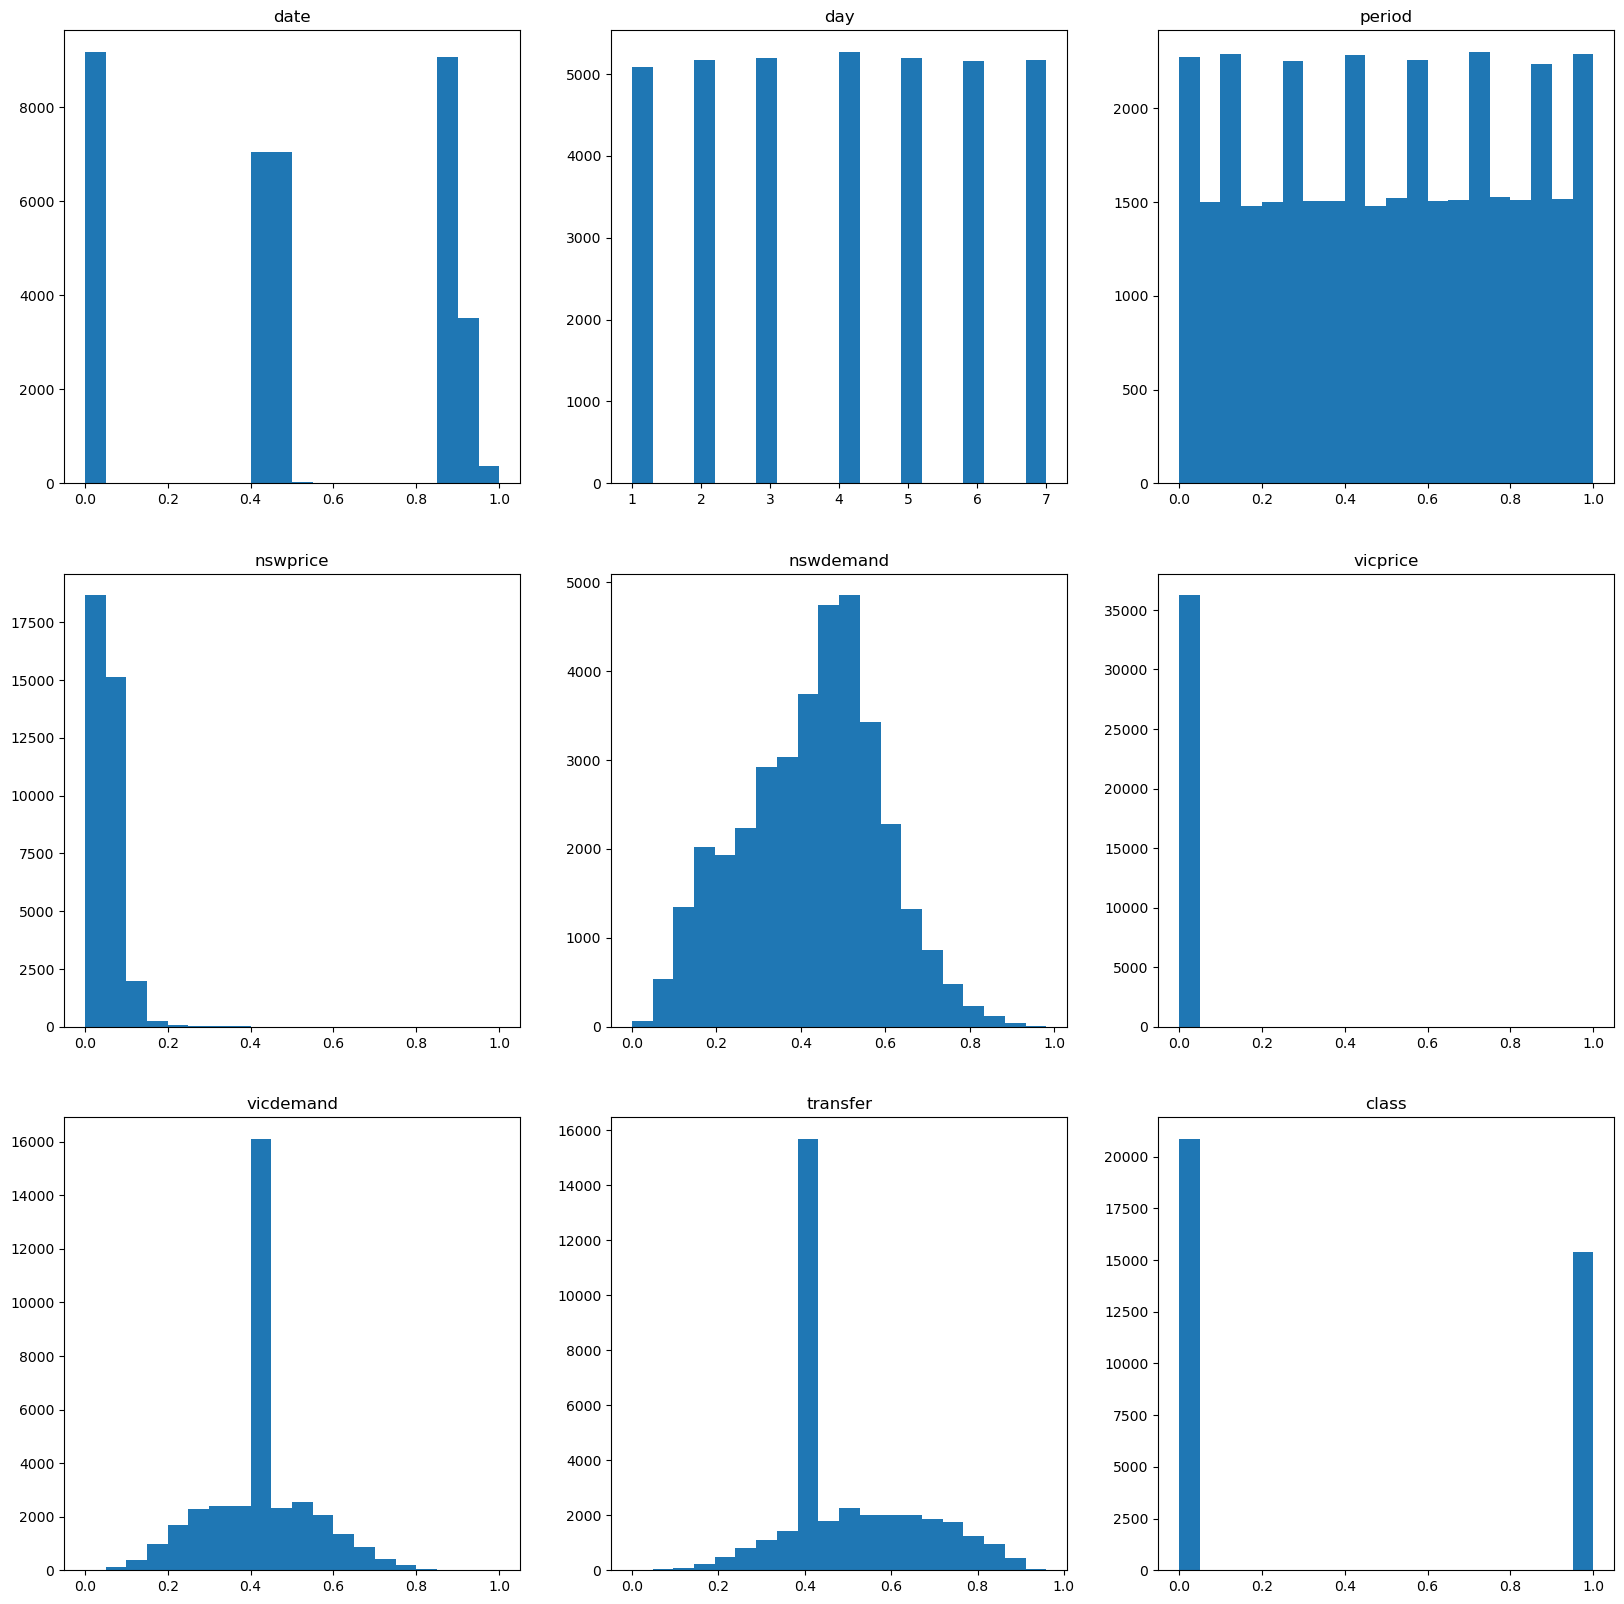

In [8]:
for ax, num_col_name in zip(plt.subplots(3, 3, figsize=(20, 20))[1].flatten(), df):
  ax.set_title(num_col_name)
  ax.hist(df[num_col_name], bins=20)

Из полученных иллюстраций видно, что в данных, скорее всего, как и ожидалось, есть некоторая периодичность. Более того, похоже, за нас уже поработали над заполнением пропусков или обработкой выбросов

При помощи <code>train_test_split</code> разобейте полученный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем варианте.

In [9]:
df

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.425556,6,0.723404,0.076258,0.311366,0.003467,0.422915,0.414912,1
1,0.867351,7,0.808511,0.028131,0.299018,0.001838,0.325738,0.832018,0
2,0.031680,1,0.723404,0.055242,0.398691,0.003467,0.422915,0.414912,0
3,0.867793,3,1.000000,0.028822,0.396162,0.001014,0.394873,0.639474,0
4,0.880536,4,0.978723,0.040741,0.468908,0.002655,0.425427,0.630702,1
...,...,...,...,...,...,...,...,...,...
36244,0.447281,2,0.723404,0.087096,0.845879,0.006061,0.687209,0.327632,1
36245,0.429583,7,0.425532,0.058034,0.372657,0.003467,0.422915,0.414912,0
36246,0.013053,5,0.468085,0.041732,0.558465,0.003467,0.422915,0.414912,0
36247,0.889739,3,0.872340,0.078179,0.730586,0.005393,0.599171,0.476754,1


In [10]:
X = df.drop(columns='class')
y = df['class']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Random Forests Classifier

Обучите модель <code>sklearn.ensemble.RandomForestClassifier</code> на тренировочных данных с параметрами, указанными в вашем индивидуальном задании. 

In [12]:
model_RF = RandomForestClassifier(random_state=41)
model_RF.fit(X_train, y_train)



RandomForestClassifier(random_state=41)

In [13]:
y_pred = model_RF.predict(X_train)

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [14]:
print(classification_report(y_train, y_pred, digits=4))


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     16685
           1     1.0000    1.0000    1.0000     12314

    accuracy                         1.0000     28999
   macro avg     1.0000    1.0000    1.0000     28999
weighted avg     1.0000    1.0000    1.0000     28999



Получили переобучение. Что же, еще раз можно ответить, что деревья принятия решений весьма склонны к переобучению.

## Добавление к лесу деревьев GridSearchCV

In [15]:
params_grid = {'n_estimators': [100,300,500],
  'max_leaf_nodes': list(range(6,10)),
  'min_samples_leaf': [1,2,3]}

Grid_Search = GridSearchCV(RandomForestClassifier(
    bootstrap=False,
    class_weight='balanced',
    n_jobs=-1,
    max_features='sqrt',
    random_state=41),
    params_grid,
    verbose=4,
    cv=3)

При помощи <code>sklearn.model_selection.GridSearchCV</code> обучите <code>RandomForestClassifier</code> на тренировочных данных c параметрами, указанными в вашем индивидуальном задании. 

Подбираемые параметры: 

<code>{'n_estimators': [100,300,500], 'max_leaf_nodes': list(range(6,10)), 'min_samples_leaf': [1,2,3]}</code>

In [16]:
Grid_Search.fit(X_train,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.771 total time=   1.5s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.771 total time=   0.2s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.768 total time=   0.3s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.771 total time=   0.7s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.772 total time=   0.7s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.767 total time=   0.8s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.771 total time=   1.1s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.773 total time=   1.1s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.768 total time=   1.1s
[CV 1/3] END max_leaf_nodes=6

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False,
                                              class_weight='balanced',
                                              n_jobs=-1, random_state=41),
             param_grid={'max_leaf_nodes': [6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 300, 500]},
             verbose=4)

Выберите лучшую модель. Рекомендуем использовать поле <code>best_estimator_</code> объекта класса <code>grid_search</code>. В поле <code>best_params_</code> этого же объекта можно найти параметры лучшей модели. 

In [17]:
Grid_Search.best_params_

{'max_leaf_nodes': 9, 'min_samples_leaf': 1, 'n_estimators': 500}

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [18]:
y_pred = Grid_Search.predict(X_train)
print(classification_report(y_train, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7819    0.8783    0.8273     16685
           1     0.8021    0.6680    0.7289     12314

    accuracy                         0.7890     28999
   macro avg     0.7920    0.7732    0.7781     28999
weighted avg     0.7905    0.7890    0.7855     28999



Постройте <code>classification_report</code> полученной модели на **тестовых данных**. Введите значение точности модели на **тестовых данных**.

In [19]:
y_pred = Grid_Search.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7829    0.8800    0.8286      4175
           1     0.8041    0.6686    0.7301      3075

    accuracy                         0.7903      7250
   macro avg     0.7935    0.7743    0.7794      7250
weighted avg     0.7919    0.7903    0.7868      7250



От переобучения избавились, но точность кажется низкой.

Один из плюсов случайного леса — можно посмотреть на важность признаков при классификации (обратная задача). Значения важности можно найти в поле <code>feature_importances_</code> модели. Определите название самого важного признака модели.

In [20]:
model_RF.feature_importances_

array([0.17555935, 0.05465095, 0.10191969, 0.30359676, 0.12727108,
       0.11832421, 0.06471698, 0.05396096])

In [21]:
model_RF.feature_importances_.max()

0.30359676344796716

In [22]:
df.columns[np.where(model_RF.feature_importances_ == model_RF.feature_importances_.max())][0]

'nswprice'

Попробуем улучшить результаты, используя другие виды ансамблей.

# Voting Classifier

In [24]:
eclf3 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],voting='soft', weights=[2,1,1],flatten_transform=True)
eclf3 = eclf3.fit(X, y)

NameError: name 'clf1' is not defined

In [29]:
model_LR = LogisticRegression(solver='liblinear', random_state=41)
model_SVC = SVC(random_state=41)
model_SGD = SGDClassifier(random_state=41)

Обучает все модели, поданные на вход, и предсказывает финальный результат либо по большему числу одинаковых ответов, которые дали модели (hard), либо вычисляет вероятность отнесения объектов к классам по всем моделям и берет argmax.

Используйте объект <code>sklearn.ensemble.VotingClassifier</code> с параметром <code>voting='hard'</code>. В качестве базовых алгоритмов используйте классификаторы с соответствующими параметрами, указанными в вашем индивидуальном задании. Обучите модель на тренировочных данных

In [30]:
model_VC = VotingClassifier(estimators=[('model_LR', model_LR), ('model_SVC', model_SVC), ('model_SGD', model_SGD)],voting='hard')

In [31]:
model_VC.fit(X_train,y_train)

VotingClassifier(estimators=[('model_LR',
                              LogisticRegression(random_state=41,
                                                 solver='liblinear')),
                             ('model_SVC', SVC(random_state=41)),
                             ('model_SGD', SGDClassifier(random_state=41))])

Вычислите точность модели на **тренировочных данных**

In [32]:
y_pred = model_VC.predict(X_train)
print(classification_report(y_train, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7138    0.9250    0.8058     16685
           1     0.8303    0.4976    0.6223     12314

    accuracy                         0.7435     28999
   macro avg     0.7721    0.7113    0.7140     28999
weighted avg     0.7633    0.7435    0.7279     28999



Вычислите точность модели на **тестовых данных**

In [33]:
y_pred = model_VC.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7137    0.9229    0.8049      4175
           1     0.8260    0.4972    0.6208      3075

    accuracy                         0.7423      7250
   macro avg     0.7698    0.7101    0.7128      7250
weighted avg     0.7613    0.7423    0.7268      7250



# Bagging Classifier

Создает несколько объектов одного класса (несколько моделей) и обучает их на непересекающихся подмножествах тренировочных данных, а дальше усредняет ответы.

На основе <code>sklearn.ensemble.BaggingClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [34]:
bgclr = BaggingClassifier(DecisionTreeClassifier(class_weight='balanced'),
    max_samples=0.5, 
    max_features=0.5,
    bootstrap=False,
  random_state=41)
bgclr.fit(X_train, y_train)

BaggingClassifier(bootstrap=False,
                  estimator=DecisionTreeClassifier(class_weight='balanced'),
                  max_features=0.5, max_samples=0.5, random_state=41)

Вычислите точность модели на **тренировочных данных**

In [35]:
y_pred = bgclr.predict(X_train)
print(classification_report(y_train, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9690    0.9887    0.9787     16685
           1     0.9842    0.9571    0.9705     12314

    accuracy                         0.9753     28999
   macro avg     0.9766    0.9729    0.9746     28999
weighted avg     0.9755    0.9753    0.9752     28999



Вычислите точность модели на **тестовых данных**

In [36]:
y_pred = bgclr.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8418    0.9111    0.8751      4175
           1     0.8642    0.7675    0.8130      3075

    accuracy                         0.8502      7250
   macro avg     0.8530    0.8393    0.8440      7250
weighted avg     0.8513    0.8502    0.8487      7250



# Gradient Boosting Classifier

Градиентный бустинг работает примерно так: создается несколько объектов класса (несколько моделей), они выстраиваются в цепочку так, чтобы каждый следующий пытался исправить ошибки предыдущего. Склонен к переобучению.

Обучите модель на основе <code>sklearn.ensemble.GradientBoostingClassifier</code> с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [37]:
model_GBC = GradientBoostingClassifier(n_estimators=500, learning_rate=0.8, random_state=41, max_depth=2)
model_GBC.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.8, max_depth=2, n_estimators=500,
                           random_state=41)

Вычислите точность модели на **тренировочных данных**

In [38]:
y_pred = model_GBC.predict(X_train)
print(classification_report(y_train, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9345    0.9471    0.9407     16685
           1     0.9270    0.9100    0.9184     12314

    accuracy                         0.9313     28999
   macro avg     0.9307    0.9285    0.9296     28999
weighted avg     0.9313    0.9313    0.9313     28999



Вычислите точность модели на **тестовых данных**

In [39]:
y_pred = model_GBC.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9097    0.9140    0.9118      4175
           1     0.8825    0.8767    0.8796      3075

    accuracy                         0.8982      7250
   macro avg     0.8961    0.8954    0.8957      7250
weighted avg     0.8981    0.8982    0.8982      7250



# AdaBoost Classifier

Работает похожим на градиентный бустинг образом, только последующие модели не пытаются исправить ошибку предыдущих: сначала первый объект обучается на всем датасете, а следующий на основе опыта предыдущего обновляет свои веса так, чтобы исправлять ошибочные предсказания.

На основе <code>sklearn.ensemble.AdaBoostClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [40]:
model_ABC = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    n_estimators=300,
    learning_rate=0.5,
    random_state=41)
model_ABC.fit(X_train,y_train)

/Users/muzafarov/anaconda3/envs/ML_OE/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=3),
                   learning_rate=0.5, n_estimators=300, random_state=41)

Вычислите точность модели на **тренировочных данных**

In [41]:
y_pred = model_ABC.predict(X_train)
print(classification_report(y_train, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9601    0.9335    0.9466     16685
           1     0.9131    0.9475    0.9300     12314

    accuracy                         0.9394     28999
   macro avg     0.9366    0.9405    0.9383     28999
weighted avg     0.9402    0.9394    0.9395     28999



Вычислите точность модели на **тестовых данных**

In [42]:
y_pred = model_ABC.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9268    0.8970    0.9116      4175
           1     0.8660    0.9037    0.8845      3075

    accuracy                         0.8999      7250
   macro avg     0.8964    0.9004    0.8981      7250
weighted avg     0.9010    0.8999    0.9001      7250



# Stacking Classifier

Обучает несколько объектов класса (несколько моделей) на всем наборе данных, а после — обучает отдельный классификатор на метданных — ответах, полученных обученными ранее моделями.

Используйте объект <code>sklearn.ensemble.StackingClassifier</code>. Базовые алгоритмы и решающий, а также соответствующие параметры указанны в вашем индивидуальном задании. Обучите модель на тренировочных данных.

In [55]:
estimators = [('model_rf', RandomForestClassifier(random_state=41)), ('model_SVC', SVC(random_state=41))]


In [56]:
model_SC = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=41))

In [57]:
model_SC.fit(X_train,y_train)

StackingClassifier(estimators=[('model_rf',
                                RandomForestClassifier(random_state=41)),
                               ('model_SVC', SVC(random_state=41))],
                   final_estimator=LogisticRegression(random_state=41))

Вычислите точность модели на **тренировочных данных**

In [58]:
y_pred = model_SC.predict(X_train)
print(classification_report(y_train, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998     16685
           1     1.0000    0.9994    0.9997     12314

    accuracy                         0.9998     28999
   macro avg     0.9998    0.9997    0.9998     28999
weighted avg     0.9998    0.9998    0.9998     28999



Вычислите точность модели на **тестовых данных**

In [59]:
y_pred = model_SC.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9114    0.9236    0.9174      4175
           1     0.8943    0.8780    0.8861      3075

    accuracy                         0.9043      7250
   macro avg     0.9029    0.9008    0.9018      7250
weighted avg     0.9041    0.9043    0.9042      7250



In [149]:
df_test = pd.read_csv('/Users/muzafarov/Desktop/MyEducation/ML_OE/electricity_reserved.csv')

In [150]:
df

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.425556,6,0.723404,0.076258,0.311366,0.003467,0.422915,0.414912,1
1,0.867351,7,0.808511,0.028131,0.299018,0.001838,0.325738,0.832018,0
2,0.031680,1,0.723404,0.055242,0.398691,0.003467,0.422915,0.414912,0
3,0.867793,3,1.000000,0.028822,0.396162,0.001014,0.394873,0.639474,0
4,0.880536,4,0.978723,0.040741,0.468908,0.002655,0.425427,0.630702,1
...,...,...,...,...,...,...,...,...,...
36244,0.447281,2,0.723404,0.087096,0.845879,0.006061,0.687209,0.327632,1
36245,0.429583,7,0.425532,0.058034,0.372657,0.003467,0.422915,0.414912,0
36246,0.013053,5,0.468085,0.041732,0.558465,0.003467,0.422915,0.414912,0
36247,0.889739,3,0.872340,0.078179,0.730586,0.005393,0.599171,0.476754,1


In [151]:
df_test

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer
0,0.881111,3,0.595745,0.035937,0.527968,0.002443,0.545054,0.391667
1,0.898854,7,0.744681,0.084514,0.529902,0.005399,0.449249,0.664474
2,0.452015,4,0.000000,0.040891,0.591639,0.002833,0.449508,0.491667
3,0.446706,3,0.893617,0.069893,0.623921,0.004701,0.486277,0.586842
4,0.890005,2,0.914894,0.027441,0.577060,0.001901,0.528742,0.419298
...,...,...,...,...,...,...,...,...
9058,0.876421,1,0.148936,0.018284,0.097888,0.000816,0.174262,0.841667
9059,0.871731,4,0.936170,0.048547,0.447932,0.003278,0.437856,0.573684
9060,0.027565,6,0.042553,0.052150,0.206486,0.003467,0.422915,0.414912
9061,0.000442,5,0.446809,0.149634,0.545076,0.003467,0.422915,0.414912


In [158]:
X_train = df.drop(columns='class')
y_train = df['class']
X_test = df_test

In [159]:
model_SC.fit(X_train,y_train)
y_pred = model_SC.predict(X_test)

/Users/muzafarov/anaconda3/envs/ML_OE/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [160]:
with open(f'/Users/muzafarov/Desktop/MyEducation/ML_OE/Ensambles_final.txt', 'w') as f:
    f.write(f'{list(y_pred)}')

In [162]:
bgclr = BaggingClassifier(DecisionTreeClassifier(class_weight='balanced'),
    max_samples=0.5, 
    max_features=0.5,
    bootstrap=False,
  random_state=41)

rfc = RandomForestClassifier(bootstrap=False, class_weight='balanced', max_leaf_nodes=9, n_jobs=-1, random_state=41)
svc = SVC(random_state=41)
abclr = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    n_estimators=300,
    learning_rate=0.5,
    random_state=41)
gbclr = GradientBoostingClassifier(n_estimators=500, learning_rate=0.8, random_state=41, max_depth=2)
lgr = LogisticRegression(random_state=41)

stckclr = StackingClassifier(estimators=[('gbclr', gbclr), ('abclr', abclr), ('bgclr', bgclr), ('svc', svc), ('lgr', lgr)], final_estimator=rfc)
stckclr.fit(X_train, y_train)

/Users/muzafarov/anaconda3/envs/ML_OE/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/muzafarov/anaconda3/envs/ML_OE/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/muzafarov/anaconda3/envs/ML_OE/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/muzafarov/anaconda3/envs/ML_OE/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/muzafarov/anaconda3/envs/ML_OE/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was ren

StackingClassifier(estimators=[('gbclr',
                                GradientBoostingClassifier(learning_rate=0.8,
                                                           max_depth=2,
                                                           n_estimators=500,
                                                           random_state=21)),
                               ('abclr',
                                AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                         max_depth=3),
                                                   learning_rate=0.5,
                                                   n_estimators=300,
                                                   random_state=21)),
                               ('bgclr',
                                BaggingClassifier(bootstrap=False,
                                                  estimator=DecisionTreeClassifier(class_weight='balanced'),
                                                  max_features=0.5,
                                                  max_samples=0.5,
                                                  random_state=21)),
                               ('svc', SVC(random_state=21)),
                               ('lgr', LogisticRegression(random_state=21))],
                   final_estimator=RandomForestClassifier(bootstrap=False,
                                                          class_weight='balanced',
                                                          max_leaf_nodes=9,
                                                          n_jobs=-1,
                                                          random_state=21))

In [164]:
y_pred = stckclr.predict(X_test)
with open(f'/Users/muzafarov/Desktop/MyEducation/ML_OE/Ensambles_final.txt', 'w') as f:
  f.write(f'{list(y_pred)}')
